<a href="https://colab.research.google.com/github/1-suresh/spam_email_detection_with_ml/blob/main/EMAIL_SPAM_DETECTION_WITH_MACHINE_LEARNING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# data preprocessing
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import re
from collections import Counter
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder

# Model Building
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Importing the Dataset

In [ ]:
data = pd.read_csv("spam (1).csv",encoding='latin1')

In [ ]:
data.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
1990,ham,HI DARLIN IVE JUST GOT BACK AND I HAD A REALLY...,NaN,NaN,NaN
539,ham,"I am in tirupur da, once you started from offi...",NaN,NaN,NaN
782,ham,Beerage?,NaN,NaN,NaN
3124,spam,1st wk FREE! Gr8 tones str8 2 u each wk. Txt N...,NaN,NaN,NaN
5416,ham,My slave! I want you to take 2 or 3 pictures o...,NaN,NaN,NaN


# Data Cleaning

In [ ]:
data.shape

(5572, 5)

In [ ]:
data.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)

In [ ]:
data.rename(columns={'v1': 'result', 'v2': 'emails'}, inplace=True)

In [ ]:
data.head(5)

,result,emails
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
data.isnull().sum()

result    0
emails    0
dtype: int64

In [ ]:
data.duplicated().sum()

403

In [ ]:
data = data.drop_duplicates(keep='first')

In [ ]:
data.shape

(5169, 2)

# EDA

# 1) Distribution of Labels

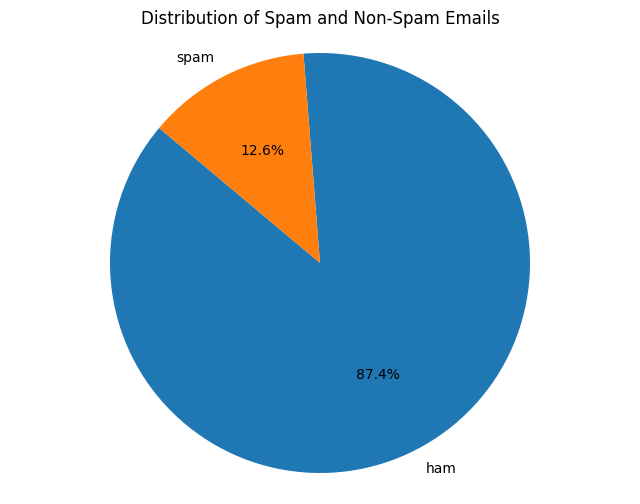

In [ ]:
data['result'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
plt.pie(data['result'].value_counts(), labels=data['result'].value_counts().index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Spam and Non-Spam Emails')
plt.axis('equal')
plt.show()

### From the above graph we can see most emails in the dataset (87.4%) are non-spam (ham), while only a smaller portion (12.6%) are classified as spam. This difference is important because it affects how well our model can spot spam emails. Since there are many more non-spam emails, the model might become biased and miss some spam emails. To fix this, we need to use special techniques when training and testing our model. By doing this, we can make sure our model is good at finding both spam and non-spam emails, keeping our email inboxes safe and clutter-free.

In [ ]:
data['Length'] = data['emails'].apply(len)
data['num_words'] = data['emails'].apply(word_tokenize).apply(len)
data['num_sentence'] = data['emails'].apply(sent_tokenize).apply(len)

In [ ]:
data.head(2)

,result,emails,Length,num_words,num_sentence
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2
1,ham,Ok lar... Joking wif u oni...,29,8,2


# 2) Average Length of Emails for Spam and Ham

Average Length of Spam Emails: 137.89127105666157
Average Length of Ham Emails: 70.45925597874225


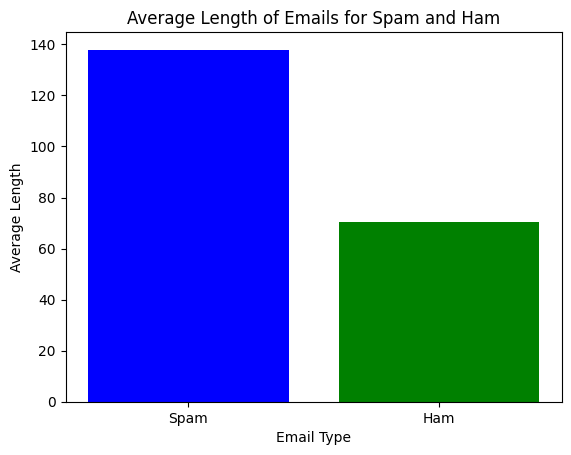

In [ ]:
avg_length_spam = data[data['result'] == 'spam']['Length'].mean()
avg_length_ham = data[data['result'] == 'ham']['Length'].mean()
print("Average Length of Spam Emails:", avg_length_spam)
print("Average Length of Ham Emails:", avg_length_ham)

# Plotting the graph
plt.bar(['Spam', 'Ham'], [avg_length_spam, avg_length_ham], color=['Blue', 'green'])
plt.title('Average Length of Emails for Spam and Ham')
plt.xlabel('Email Type')
plt.ylabel('Average Length')
plt.show()

#### After looking at the lengths of spam and regular (ham) emails, we found that spam emails are much longer on average, around 137 characters. On the other hand, regular emails are much shorter, averaging about 70 characters. This means that spam emails tend to be more wordy and detailed, possibly because they're trying to grab your attention with lots of information. Regular emails, like the ones you get from friends or for work, are usually shorter and to the point. Understanding this helps us make better tools to filter out spam and keep our inboxes organized.

# 3) Average Word of Emails for Spam and Ham

Average Words of Spam Emails: 27.6676875957121
Average Words of Ham Emails: 17.12378210806023


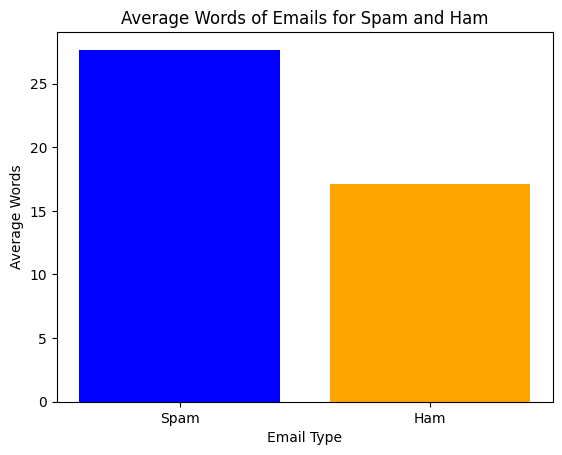

In [ ]:
avg_word_spam = data[data['result'] == 'spam']['num_words'].mean()
avg_word_ham = data[data['result'] == 'ham']['num_words'].mean()
print("Average Words of Spam Emails:", avg_word_spam)
print("Average Words of Ham Emails:", avg_word_ham)

# Plotting the graph
plt.bar(['Spam', 'Ham'], [avg_word_spam, avg_word_ham], color=['Blue', 'orange'])
plt.title('Average Words of Emails for Spam and Ham')
plt.xlabel('Email Type')
plt.ylabel('Average Words')
plt.show()

#### From the above graph we can see that spam emails are longer, with an average of about 27 words per email. On the other hand, regular ham emails are shorter, averaging around 17 words per email. This means spam emails tend to be more wordy, maybe because they contain advertisements or misleading information. Meanwhile, regular emails are more straightforward and direct. Understanding this helps us create better filters to catch spam and keep our inboxes clean from unwanted messages, making it easier to find the emails that matter to us.

# 4) Average Sentence of Emails for Spam and Ham

Average Sentence of Spam Emails: 2.970903522205207
Average Sentence of Ham Emails: 1.8201948627103632


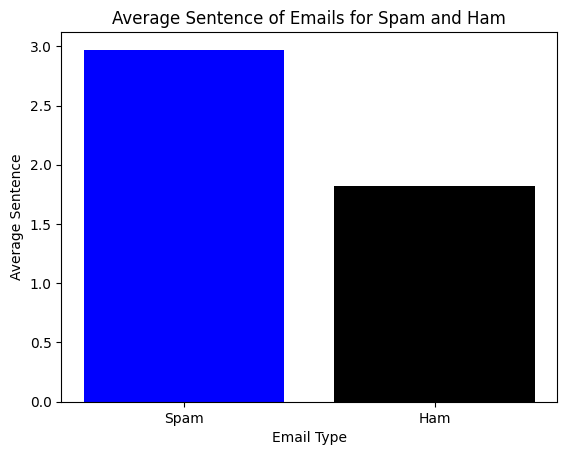

In [ ]:
avg_sentence_spam = data[data['result'] == 'spam']['num_sentence'].mean()
avg_sentence_ham = data[data['result'] == 'ham']['num_sentence'].mean()
print("Average Sentence of Spam Emails:", avg_sentence_spam)
print("Average Sentence of Ham Emails:", avg_sentence_ham)

# Plotting the graph
plt.bar(['Spam', 'Ham'], [avg_sentence_spam, avg_sentence_ham], color=['Blue', 'black'])
plt.title('Average Sentence of Emails for Spam and Ham')
plt.xlabel('Email Type')
plt.ylabel('Average Sentence')
plt.show()

#### From the above graph we can see that that spam emails tend to have longer sentences compared to regular emails. On average, spam emails have about 3 sentences, while regular emails have about 2 sentences. This means that spam emails might be trying to say more or convince you of something, while regular emails are usually shorter and more straightforward. Understanding this difference helps us build better systems to detect and filter out spam emails, keeping our email inboxes cleaner and safer for everyone to use.

# 5) Relationship between Length and Spam

Correlation coefficient between email length and spam classification: 0.38471706671430717


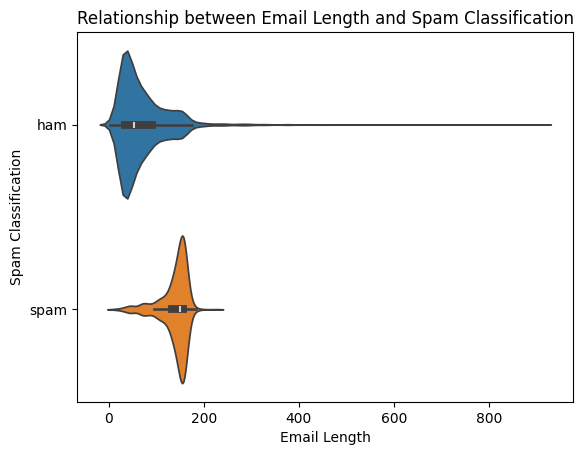

In [ ]:
correlation = data['Length'].corr((data['result'] == 'spam').astype(int))
print("Correlation coefficient between email length and spam classification:", correlation)


sns.violinplot(data=data, x='Length', y='result', hue='result')
plt.xlabel('Email Length')
plt.ylabel('Spam Classification')
plt.title('Relationship between Email Length and Spam Classification')
plt.show()

#### As we found that there is a positive correlation (correlation coefficient: 0.38) between email length and spam classification. This means that, on average, spam emails tend to be slightly longer than non-spam emails. However, it's important to note that the correlation is not very strong, indicating that other factors may also influence whether an email is classified as spam. Nonetheless, understanding this relationship can help improve spam detection algorithms by considering email length as one of the features in the classification process, alongside other relevant factors.

# 6) Relationship between Features

The Relationship between Features are                  Length  num_words  num_sentence
Length        1.000000   0.965760      0.624139
num_words     0.965760   1.000000      0.679971
num_sentence  0.624139   0.679971      1.000000


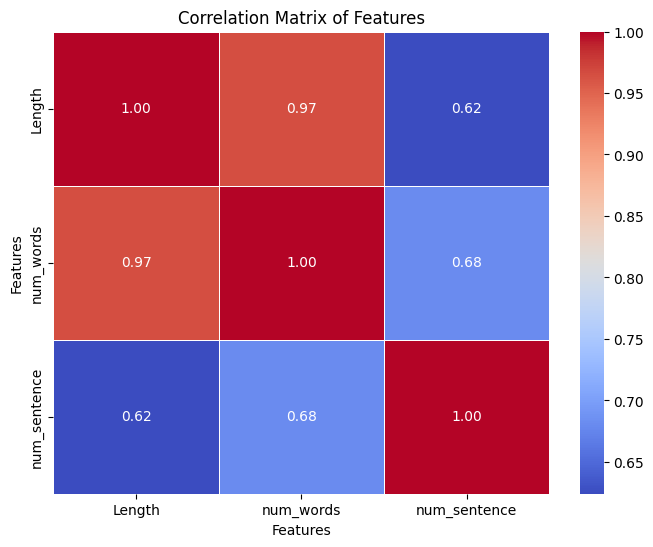

In [ ]:
correlation_matrix = data[['Length', 'num_words', 'num_sentence']].corr()
print("The Relationship between Features are ",correlation_matrix )
# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Features')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

#### The correlation matrix indicates strong positive correlations between email length and the number of words (0.97) as well as between the number of words and the number of sentences (0.68). This suggests that longer emails tend to have more words, and emails with more words tend to have more sentences. However, the correlation between email length and the number of sentences is weaker (0.62). This implies that while longer emails may have more sentences, the relationship is not as strong as with the number of words. Understanding these relationships helps us grasp how different features contribute to the overall structure and content of emails, aiding in spam classification.

## Data Preprocessing

In [ ]:
data['transform_text'] = data['emails'].str.lower()
# Tokenization
data['transform_text'] = data['transform_text'].apply(word_tokenize)

# Removing special characters
data['transform_text'] = data['transform_text'].apply(lambda x: [re.sub(r'[^a-zA-Z0-9\s]', '', word) for word in x])

# Removing stop words and punctuation
stop_words = set(stopwords.words('english'))
data['transform_text'] = data['transform_text'].apply(lambda x: [word for word in x if word not in stop_words and word not in string.punctuation])

# Stemming
ps = PorterStemmer()
data['transform_text'] = data['transform_text'].apply(lambda x: [ps.stem(word) for word in x])

# Convert the preprocessed text back to string
data['transform_text'] = data['transform_text'].apply(lambda x: ' '.join(x))

# Display the preprocessed data
print(data[['emails', 'transform_text']].head())

                                              emails  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                      transform_text  
0  go jurong point crazi avail bugi n great world...  
1                              ok lar joke wif u oni  
2  free entri 2 wkli comp win fa cup final tkt 21...  
3                u dun say earli hor u c alreadi say  
4            nah nt think goe usf live around though  


In [ ]:
data

,result,emails,Length,num_words,num_sentence,transform_text
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah nt think goe usf live around though
...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,161,35,4,2nd time tri 2 contact u u 750 pound prize 2 c...
5568,ham,Will Ì_ b going to esplanade fr home?,37,9,1,b go esplanad fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",57,15,2,piti mood suggest
5570,ham,The guy did some bitching but I acted like i'd...,125,27,1,guy bitch act like interest buy someth els nex...


# 7) Most Common Words in Spam Emails

Top 10 Most Common Words in Spam Emails:
call: 321 occurrences
free: 191 occurrences
2: 157 occurrences
txt: 141 occurrences
u: 135 occurrences
text: 122 occurrences
ur: 119 occurrences
mobil: 114 occurrences
stop: 106 occurrences
repli: 103 occurrences


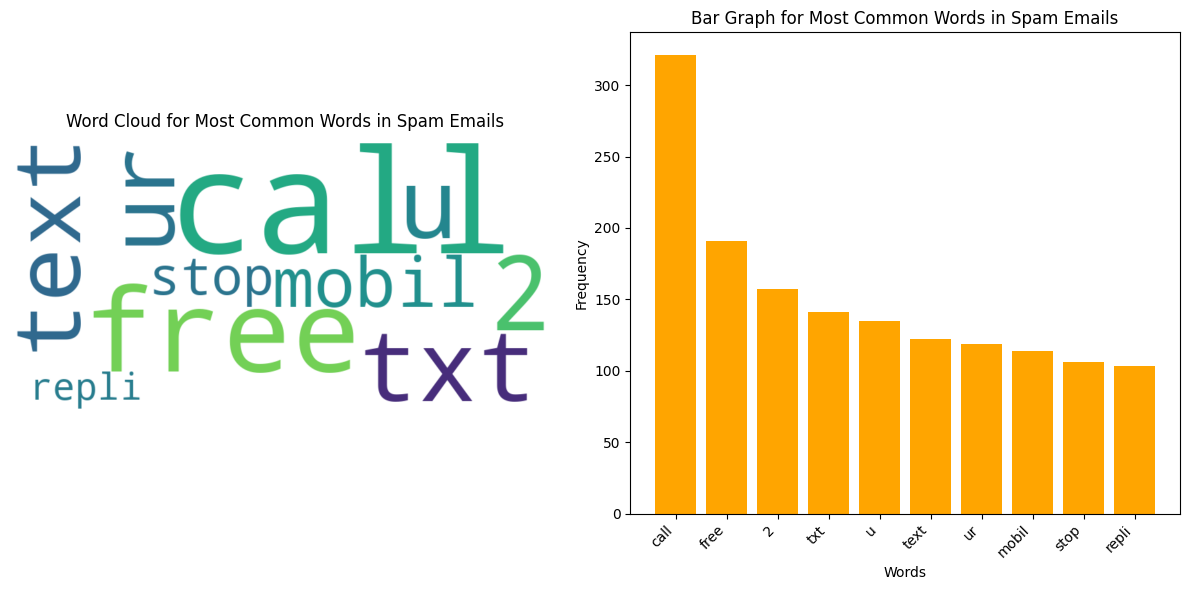

In [ ]:
spam_emails = data[data['result'] == 'spam']['transform_text']

# Tokenize the text in spam emails
spam_words = ' '.join(spam_emails).split()

# Count occurrences of each word
word_counts = Counter(spam_words)

# Find the most common words
most_common_words = word_counts.most_common(10)

print("Top 10 Most Common Words in Spam Emails:")
for word, count in most_common_words:
    print(f"{word}: {count} occurrences")

# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(most_common_words))

# Plot Word Cloud
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Most Common Words in Spam Emails')
plt.axis('off')

# Plot Bar Graph
plt.subplot(1, 2, 2)
words, counts = zip(*most_common_words)
plt.bar(words, counts, color='orange')
plt.title('Bar Graph for Most Common Words in Spam Emails')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


#### Looking at the most common words found in spam emails, we see patterns that spammers often use to catch our attention or convince us to act. Words like "call," "free," and "txt" show up frequently, suggesting offers or requests for action. This helps us understand what to watch out for in our emails to avoid falling for spam. By knowing these common tricks, we can be more careful about which emails we open or respond to, keeping our inboxes safer. Email filters also use this information to better recognize and block spam messages, making our email experience more secure.

# 8) Most Common Words in ham Emails

Top 10 Most Common Words in ham Emails:
u: 904 occurrences
go: 404 occurrences
nt: 352 occurrences
get: 352 occurrences
2: 290 occurrences
gt: 288 occurrences
lt: 287 occurrences
come: 275 occurrences
ok: 251 occurrences
got: 238 occurrences


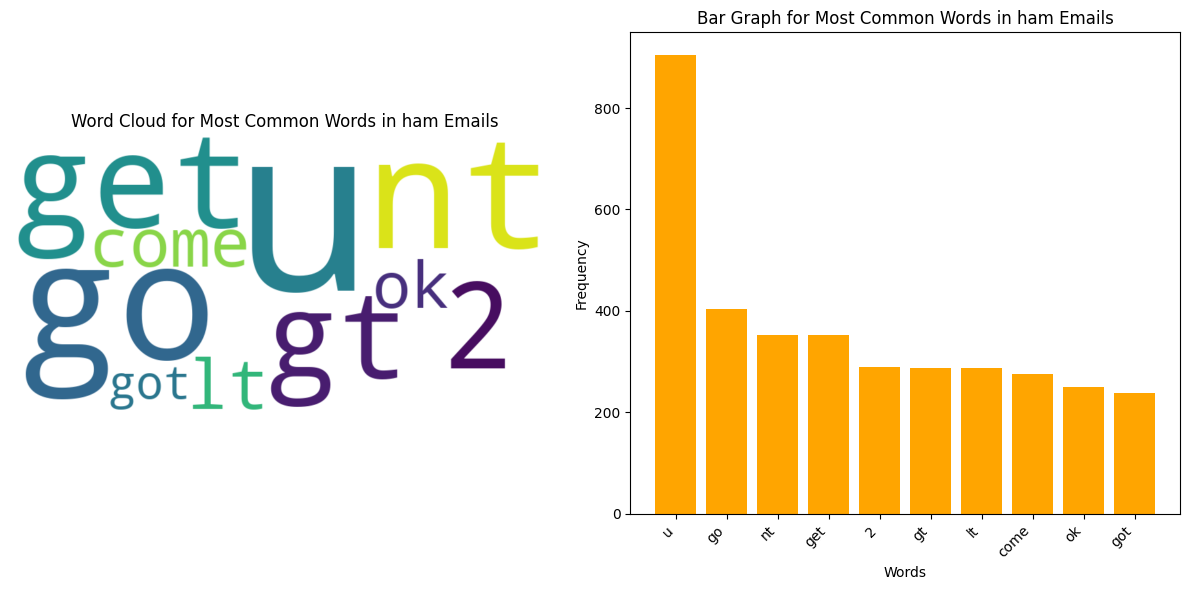

In [ ]:
ham_emails = data[data['result'] == 'ham']['transform_text']

# Tokenize the text in spam emails
ham_words = ' '.join(ham_emails).split()

# Count occurrences of each word
word_counts = Counter(ham_words)

# Find the most common words
most_common_words = word_counts.most_common(10)

print("Top 10 Most Common Words in ham Emails:")
for word, count in most_common_words:
    print(f"{word}: {count} occurrences")

# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(most_common_words))

# Plot Word Cloud
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Most Common Words in ham Emails')
plt.axis('off')

# Plot Bar Graph
plt.subplot(1, 2, 2)
words, counts = zip(*most_common_words)
plt.bar(words, counts, color='orange')
plt.title('Bar Graph for Most Common Words in ham Emails')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

#### The top 10 most common words in non-spam emails are "u," "go," "nt," "get," "2," "gt," "lt," "come," "ok," and "got." These words show how people talk in emails, with shortcuts like "u" instead of "you" and "nt" for "not." They also reveal common topics like going somewhere or confirming things with "ok." Understanding these words helps in spotting normal emails. It tells us what to expect in regular messages, making it easier to spot unusual or suspicious ones, like spam.

# Label Encoding

In [ ]:
encoder = LabelEncoder()
data['result'] = encoder.fit_transform(data['result'])

In [ ]:
data.sample(2)

,result,emails,Length,num_words,num_sentence,transform_text
5405,0,So how many days since then?,28,7,1,mani day sinc
5160,0,Ok... Then r we meeting later?,30,8,1,ok r meet later


# Model Building

#### convert the input data into vector , so here we will use TfidfVectorizer


In [ ]:
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(data['transform_text']).toarray()
y = data['result']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
X.shape

(5169, 3000)

## Model 1) SVC

In [ ]:
svc_classifier = SVC()
svc_classifier.fit(X_train, y_train)
y_pred_svc = svc_classifier.predict(X_test)
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print(f"SVM Accuracy: {accuracy_svc:.2f}")
print("confusion Matrix :",confusion_matrix(y_test,y_pred_svc))
print("Precision Score: ",precision_score(y_test,y_pred_svc))

SVM Accuracy: 0.98
confusion Matrix : [[889   0]
 [ 25 120]]
Precision Score:  1.0


## Model 2) Random Forest classifier

In [ ]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")
print("confusion Matrix :",confusion_matrix(y_test,y_pred_rf))
print("Precision Score: ",precision_score(y_test,y_pred_rf))

Random Forest Accuracy: 0.98
confusion Matrix : [[888   1]
 [ 22 123]]
Precision Score:  0.9919354838709677


## Model 3) Naive Bayes classifier

In [ ]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
y_pred_nb = nb_classifier.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Accuracy: {accuracy_nb:.2f}")
print("confusion Matrix :",confusion_matrix(y_test,y_pred_nb))
print("Precision Score: ",precision_score(y_test,y_pred_nb))

Naive Bayes Accuracy: 0.97
confusion Matrix : [[888   1]
 [ 25 120]]
Precision Score:  0.9917355371900827


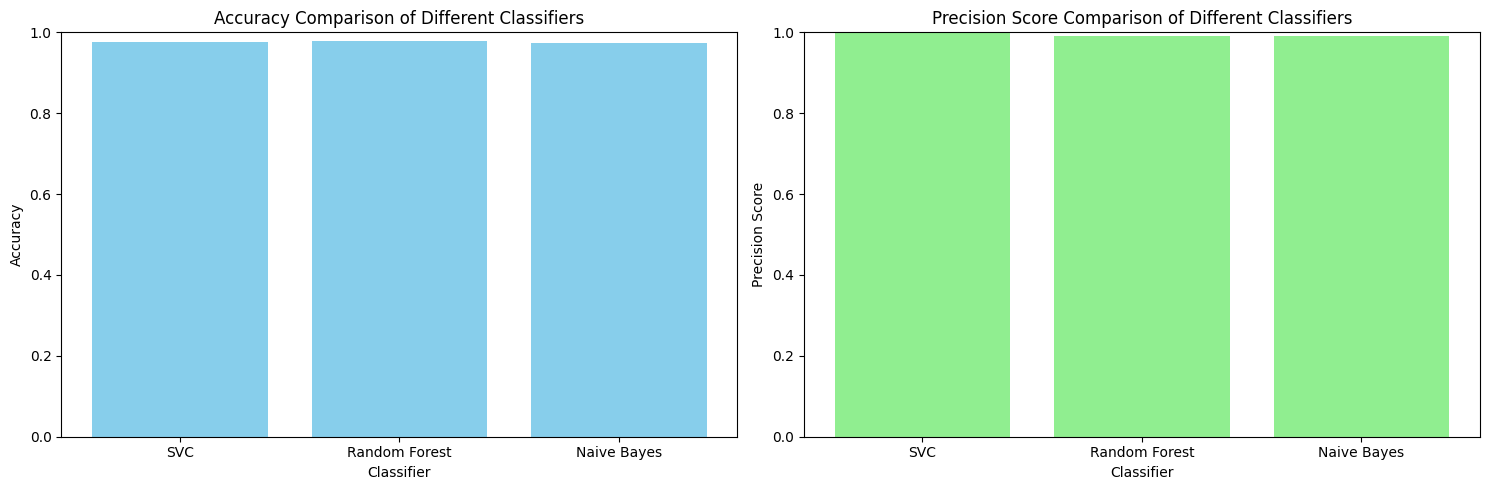

In [ ]:
# Calculate precision scores for each classifier
precision_svc = precision_score(y_test, y_pred_svc)
precision_rf = precision_score(y_test, y_pred_rf)
precision_nb = precision_score(y_test, y_pred_nb)

# Create lists to store accuracies and precision scores
classifiers = ['SVC', 'Random Forest', 'Naive Bayes']
accuracies = [accuracy_svc, accuracy_rf, accuracy_nb]
precision_scores = [precision_svc, precision_rf, precision_nb]

# Plot bar graph for accuracies and precision scores side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot bar graph for accuracies
axes[0].bar(classifiers, accuracies, color='skyblue')
axes[0].set_xlabel('Classifier')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Comparison of Different Classifiers')
axes[0].set_ylim(0, 1)

# Plot bar graph for precision scores
axes[1].bar(classifiers, precision_scores, color='lightgreen')
axes[1].set_xlabel('Classifier')
axes[1].set_ylabel('Precision Score')
axes[1].set_title('Precision Score Comparison of Different Classifiers')
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()


#### After sorting the model we find that SVC performs the best. So, we'll use  SVC to make price predictions with svc. predict(). This process helps us choose the most accurate model for predicting.

# Model Prediction

In [ ]:
new_emails = [
    "Get a free iPhone now!",
    "Hey, how's it going?",
    "Congratulations! You've won a prize!",
    "Reminder: Meeting at 2 PM tomorrow."
]

# Convert new data into numerical vectors using the trained tfidf_vectorizer
new_X = tfidf.transform(new_emails)
new_X_dense = new_X.toarray()

# Use the trained SVM model to make predictions
svm_predictions = svc_classifier.predict(new_X_dense)

# Print the predictions
for email, prediction in zip(new_emails, svm_predictions):
    if prediction == 1:
        print(f"'{email}' is predicted as spam.")
    else:
        print(f"'{email}' is predicted as ham.")

'Get a free iPhone now!' is predicted as ham.
'Hey, how's it going?' is predicted as ham.
'Congratulations! You've won a prize!' is predicted as spam.
'Reminder: Meeting at 2 PM tomorrow.' is predicted as ham.


# User Input Data Prediction

In [ ]:
def predict_email(email):
    # Convert email into numerical vector using the trained TF-IDF vectorizer
    email_vector = tfidf.transform([email])

    # Convert sparse matrix to dense array
    email_vector_dense = email_vector.toarray()

    # Use the trained SVM model to make predictions
    prediction = svc_classifier.predict(email_vector_dense)

    # Print the prediction
    if prediction[0] == 1:
        print("The email is predicted as spam.")
    else:
        print("The email is predicted as ham.")

# Get user input for email
user_email = input("Enter the email text: ")

# Predict whether the input email is spam or ham
predict_email(user_email)

Enter the email text: Congratulations! You've won a prize!
The email is predicted as spam.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Punctuations
import string
# Pandas
import pandas as pd
# Remove Stopwords
from nltk.corpus import stopwords
# Regular Expressions
import re
# Import PorterStemmer from NLTK Library
from nltk.stem.porter import PorterStemmer
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB , MultinomialNB , BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
# Metrix and Train Test
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
data.head()

,result,emails,Length,num_words,num_sentence,transform_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah nt think goe usf live around though


In [ ]:
print(f'Null Values in Train Dataset is : {data.isnull().sum().sum()}')

Null Values in Train Dataset is : 0


In [ ]:
# Duplicates
print(f"Duplicates values in Train Dataset is : {data.duplicated().sum()}")

Duplicates values in Train Dataset is : 0


In [ ]:
data.isnull().sum()

result            0
emails            0
Length            0
num_words         0
num_sentence      0
transform_text    0
dtype: int64

In [ ]:
print(data['transform_text'][0])
print(data['transform_text'][1])
print(data['transform_text'][2])


go jurong point crazi avail bugi n great world la e buffet cine got amor wat
ok lar joke wif u oni
free entri 2 wkli comp win fa cup final tkt 21st may 2005 text fa 87121 receiv entri question std txt rate c appli 08452810075over18


In [ ]:
# 1. LowerCase
data['transform_text'] = data['transform_text'].str.lower()

# Head
data.head()

,result,emails,Length,num_words,num_sentence,transform_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah nt think goe usf live around though


In [ ]:
df_train=data


In [ ]:
df_train['transform_text'] = df_train['transform_text'].str.replace('#','')
df_train['transform_text'] = df_train['transform_text'].str.replace('@','')
df_train['transform_text'] = df_train['transform_text'].str.replace(r'^https?:\/\/.*[\r\n]*','')

In [ ]:
import string
df_train['transform_text'] = df_train['transform_text'].str.translate(str.maketrans('', '', string.punctuation))

# Head
df_train.head()

,result,emails,Length,num_words,num_sentence,transform_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah nt think goe usf live around though


In [ ]:
# 6. Intilize Stopwords
stop_words = stopwords.words('english')

# Apply Stopwords
df_train['transform_text'] = df_train['transform_text'].apply(lambda x : ' '.join([word for word in x.split()if word not in (stop_words)]))

# Head
df_train.head()

,result,emails,Length,num_words,num_sentence,transform_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah nt think goe usf live around though


In [ ]:
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

In [ ]:
def chat_conversion(text):
    new_text = []
    for i in text.split():
        if i.upper() in chat_words:
            new_text.append(chat_words[i.upper()])
        else:
            new_text.append(i)
    return " ".join(new_text)

# Calling Function
df_train['transform_text'] = df_train['transform_text'].apply(chat_conversion)

# Head
df_train.head()


,result,emails,Length,num_words,num_sentence,transform_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif You oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,You dun say earli hor You c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah nt think goe usf live around though


In [ ]:
# 7. Handling ChatWords
# Function
def chat_conversion(text):
    new_text = []
    for i in text.split():
        if i.upper() in chat_words:
            new_text.append(chat_words[i.upper()])
        else:
            new_text.append(i)
    return " ".join(new_text)

# Calling Function
df_train['transform_text'] = df_train['transform_text'].apply(chat_conversion)

# Head
df_train.head()


,result,emails,Length,num_words,num_sentence,transform_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif You oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,You dun say earli hor You c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah nt think goe usf live around though


In [ ]:
# 8. Tokenization
from nltk.tokenize import sent_tokenize

# Apply sent_tokenize
df_train['text_sent_token'] = df_train['transform_text'].apply(sent_tokenize)

# Head
df_train.head()

,result,emails,Length,num_words,num_sentence,transform_text,text_sent_token
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...,[go jurong point crazi avail bugi n great worl...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif You oni,[ok lar joke wif You oni]
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...,[free entri 2 wkli comp win fa cup final tkt 2...
3,0,U dun say so early hor... U c already then say...,49,13,1,You dun say earli hor You c alreadi say,[You dun say earli hor You c alreadi say]
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah nt think goe usf live around though,[nah nt think goe usf live around though]


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# 9. Stemming

# Intilize Stemmer
stemmer = PorterStemmer()

# This Function Will Stem Words
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

# Calling
df_train['stem_msg'] = df_train['transform_text'].apply(stem_words)

# Head
df_train.head()

,result,emails,Length,num_words,num_sentence,transform_text,text_sent_token,stem_msg
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...,[go jurong point crazi avail bugi n great worl...,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif You oni,[ok lar joke wif You oni],ok lar joke wif you oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...,[free entri 2 wkli comp win fa cup final tkt 2...,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,You dun say earli hor You c alreadi say,[You dun say earli hor You c alreadi say],you dun say earli hor you c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah nt think goe usf live around though,[nah nt think goe usf live around though],nah nt think goe usf live around though


In [ ]:
cv = CountVectorizer()

In [ ]:
X = cv.fit_transform(df_train['stem_msg']).toarray()

In [ ]:
# Intlize CountVectorizer
cv = CountVectorizer()

# Fitting CountVectorizer on X
X = cv.fit_transform(df_train['stem_msg']).toarray()

In [ ]:
X.shape

(5169, 7510)

In [ ]:
y = df_train['result']

In [ ]:
y.shape

(5169,)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# Fitting Encoder
y = le.fit_transform(y)

# Y Values
y

array([0, 0, 1, ..., 0, 0, 0])

In [ ]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
xgb = XGBClassifier(n_estimators=50, random_state=2)

In [ ]:
# Initlize Models
# Support Vector MAchine
svc = SVC(kernel='sigmoid', gamma=1.0)
# KNeighbours
knc = KNeighborsClassifier()
# Multinomial NaiveBayes
mnb = MultinomialNB()
# Decision Tree
dtc = DecisionTreeClassifier(max_depth=5)
# Logistic Regression
lrc = LogisticRegression(solver='liblinear', penalty='l1')
# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
# AddaBoost Classifier
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
# Extra Tree Classifier a Ensemble Method
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
# XGB Classifier
xgb = XGBClassifier(n_estimators=50,random_state=2)

In [ ]:
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)

In [ ]:
knc.fit(X_train, y_train)
knn_pred = knc.predict(X_test)

In [ ]:
mnb.fit(X_train, y_train)
mnb_pred = mnb.predict(X_test)

In [ ]:
dtc.fit(X_train, y_train)
dtc_pred = dtc.predict(X_test)

In [ ]:
lrc.fit(X_train, y_train)
lrc_pred = lrc.predict(X_test)

In [ ]:
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

In [ ]:
abc.fit(X_train, y_train)
abc_pred = abc.predict(X_test)

In [ ]:
etc.fit(X_train, y_train)
etc_pred = etc.predict(X_test)

In [ ]:
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

In [ ]:
# Fitting Each Model One by One
# 1. SVC
svc.fit(X_train ,y_train)
# Pred
svc_pred = svc.predict(X_test)
# Pred
rf_pred = rf.predict(X_test)
#-----------------------------
# 2. KNeighbours
knc.fit(X_train ,y_train)
# Pred
knn_pred = knc.predict(X_test)
#-----------------------------
# 3. Multinomial NaiveBayes
mnb.fit(X_train ,y_train)
# Pred
mnb_pred = mnb.predict(X_test)
#-----------------------------
# 4. Decision Tree
dtc.fit(X_train ,y_train)
# Pred
dtc_pred = dtc.predict(X_test)
#-----------------------------
# 5. Logistic Regression
lrc.fit(X_train ,y_train)
# Pred
lrc_pred = lrc.predict(X_test)
#-----------------------------
# 6. Random Forest Classifier
rfc.fit(X_train ,y_train)
# Pred
rfc_pred = rfc.predict(X_test)
#-----------------------------
# 7. AddaBoost Classifier
abc.fit(X_train ,y_train)
# Pred
abc_pred = abc.predict(X_test)
#-----------------------------
# 8.Extra Tree Classifier a Ensemble Method
etc.fit(X_train ,y_train)
# Pred
etc_pred = etc.predict(X_test)
#-----------------------------
# 9. XGB Classifier
xgb.fit(X_train ,y_train)
# Pred
xgb_pred = xgb.predict(X_test)
#-----------------------------


In [ ]:
def evaluate(y_test, svc_pred):
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  confusion = confusion_matrix(y_test, y_pred)
  return accuracy, precision, confusion

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

def evaluate(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)

    return accuracy, precision, confusion

In [ ]:
accuracy_SVC, precision_SVC, confusion_SVC = evaluate(y_test, svc_pred)
print(f"The Accuracy Score Of SVC is {accuracy_SVC}, Precision Is {precision_SVC},\nConfusion Matrix is \n{confusion_SVC} ")

The Accuracy Score Of SVC is 0.9081237911025145, Precision Is 0.725,
Confusion Matrix is 
[[852  33]
 [ 62  87]] 


In [ ]:
accuracy_KNN, precision_KNN, confusion_KNN = evaluate(y_test, knn_pred)
print(f"The Accuracy Score Of KNN is {accuracy_KNN}, Precision Is {precision_KNN},\nConfusion Matrix is \n{confusion_KNN} ")

The Accuracy Score Of KNN is 0.8984526112185687, Precision Is 1.0,
Confusion Matrix is 
[[885   0]
 [105  44]] 


In [ ]:
accuracy_MNB, precision_MNB, confusion_MNB = evaluate(y_test, mnb_pred)
print(f"The Accuracy Score Of MultinomialNB is {accuracy_MNB}, Precision Is {precision_MNB},\nConfusion Matrix is \n{confusion_MNB} ")

The Accuracy Score Of MultinomialNB is 0.9758220502901354, Precision Is 0.9246575342465754,
Confusion Matrix is 
[[874  11]
 [ 14 135]] 


In [ ]:
accuracy_DTC, precision_DTC, confusion_DTC = evaluate(y_test, dtc_pred)
print(f"The Accuracy Score Of Decision Tree is {accuracy_DTC}, Precision Is {precision_DTC},\nConfusion Matrix is \n{confusion_DTC} ")

The Accuracy Score Of Decision Tree is 0.9274661508704062, Precision Is 0.9404761904761905,
Confusion Matrix is 
[[880   5]
 [ 70  79]] 


In [ ]:
accuracy_LR, precision_LR, confusion_LR = evaluate(y_test, lrc_pred)
print(f"The Accuracy Score Of Logistic Regression is {accuracy_LR}, Precision Is {precision_LR},\nConfusion Matrix is \n{confusion_LR} ")

The Accuracy Score Of Logistic Regression is 0.9738878143133463, Precision Is 0.9692307692307692,
Confusion Matrix is 
[[881   4]
 [ 23 126]] 


In [ ]:
accuracy_RF, precision_RF, confusion_RF = evaluate(y_test, rfc_pred)
print(f"The Accuracy Score Of Random Forest Classifier is {accuracy_RF}, Precision Is {precision_RF},\nConfusion Matrix is \n{confusion_RF} ")

The Accuracy Score Of Random Forest Classifier is 0.9690522243713733, Precision Is 1.0,
Confusion Matrix is 
[[885   0]
 [ 32 117]] 


In [ ]:
accuracy_ADC, precision_ADC, confusion_ADC = evaluate(y_test, abc_pred)
print(f"The Accuracy Score Of AdaBoost Classifier is {accuracy_ADC}, Precision Is {precision_ADC},\nConfusion Matrix is \n{confusion_ADC} ")

The Accuracy Score Of AdaBoost Classifier is 0.9709864603481625, Precision Is 0.983739837398374,
Confusion Matrix is 
[[883   2]
 [ 28 121]] 


In [ ]:
accuracy_ETC, precision_ETC, confusion_ETC = evaluate(y_test, etc_pred)
print(f"The Accuracy Score Of Extra Tree Classifier is {accuracy_ETC}, Precision Is {precision_ETC},\nConfusion Matrix is \n{confusion_ETC} ")

The Accuracy Score Of Extra Tree Classifier is 0.971953578336557, Precision Is 0.9918032786885246,
Confusion Matrix is 
[[884   1]
 [ 28 121]] 


In [ ]:
accuracy_XGB, precision_XGB, confusion_XGB = evaluate(y_test, xgb_pred)
print(f"The Accuracy Score Of XGBoost Classifier is {accuracy_XGB}, Precision Is {precision_XGB},\nConfusion Matrix is \n{confusion_XGB} ")

The Accuracy Score Of XGBoost Classifier is 0.9748549323017408, Precision Is 0.992,
Confusion Matrix is 
[[884   1]
 [ 25 124]] 


In [ ]:
# 1. SVC
accuracy_SVC , precision_SVC , confusion_SVC = evaluate(y_test,svc_pred)
print(f"The Accuracy Score Of SVC is {accuracy_SVC} , Precision Is {precision_SVC} ,\nConfusion Matrix is \n{confusion_SVC} ")

print("\n")

# 2. KNN
accuracy_KNN , precision_KNN , confusion_KNN = evaluate(y_test,knn_pred)
print(f"The Accuracy Score Of KNN is {accuracy_KNN} , Precision Is {precision_KNN} ,\nConfusion Matrix is \n{confusion_KNN} ")

print("\n")

# 3.Multinomial
accuracy_MNB , precision_MNB , confusion_MNB = evaluate(y_test,mnb_pred)
print(f"The Accuracy Score Of MultinomialNB is {accuracy_MNB} , Precision Is {precision_MNB} ,\nConfusion Matrix is \n{confusion_MNB} ")

print("\n")

# 4.Decision Tree
accuracy_DTC , precision_DTC , confusion_DTC = evaluate(y_test,dtc_pred)
print(f"The Accuracy Score Of Decision Tree is {accuracy_DTC} , Precision Is {precision_DTC} ,\nConfusion Matrix is \n{confusion_DTC} ")

print("\n")

# 5.Logistic Regression
accuracy_LR , precision_LR , confusion_LR = evaluate(y_test,lrc_pred)
print(f"The Accuracy Score Of Logistic Regression is {accuracy_LR} , Precision Is {precision_LR} ,\nConfusion Matrix is \n{confusion_LR} ")

print("\n")

# 6.Random Forest Classifier
accuracy_RF , precision_RF , confusion_RF = evaluate(y_test,rfc_pred)
print(f"The Accuracy Score Of Random Forest Classifier is {accuracy_RF} , Precision Is {precision_RF} ,\nConfusion Matrix is \n{confusion_RF} ")

print("\n")

# 7.AddaBoost Classifier
accuracy_ADC , precision_ADC , confusion_ADC = evaluate(y_test,abc_pred)
print(f"The Accuracy Score Of AddaBoost Classifier is {accuracy_ADC} , Precision Is {precision_ADC} ,\nConfusion Matrix is \n{confusion_ADC} ")

print("\n")

# 8.Extra Tree Classifier a Ensemble Method
accuracy_ETC , precision_ETC , confusion_ETC = evaluate(y_test,etc_pred)
print(f"The Accuracy Score Of Extra Tree Classifier  is {accuracy_ETC} , Precision Is {precision_ETC} ,\nConfusion Matrix is \n{confusion_ETC} ")

print("\n")

# 9. XGB Classifier
accuracy_XGB , precision_XGB , confusion_XGB = evaluate(y_test,xgb_pred)
print(f"The Accuracy Score Of XGB Classifier is {accuracy_XGB} , Precision Is {precision_XGB} ,\nConfusion Matrix is \n{confusion_XGB} ")

The Accuracy Score Of SVC is 0.9081237911025145 , Precision Is 0.725 ,
Confusion Matrix is 
[[852  33]
 [ 62  87]] 


The Accuracy Score Of KNN is 0.8984526112185687 , Precision Is 1.0 ,
Confusion Matrix is 
[[885   0]
 [105  44]] 


The Accuracy Score Of MultinomialNB is 0.9758220502901354 , Precision Is 0.9246575342465754 ,
Confusion Matrix is 
[[874  11]
 [ 14 135]] 


The Accuracy Score Of Decision Tree is 0.9274661508704062 , Precision Is 0.9404761904761905 ,
Confusion Matrix is 
[[880   5]
 [ 70  79]] 


The Accuracy Score Of Logistic Regression is 0.9738878143133463 , Precision Is 0.9692307692307692 ,
Confusion Matrix is 
[[881   4]
 [ 23 126]] 


The Accuracy Score Of Random Forest Classifier is 0.9690522243713733 , Precision Is 1.0 ,
Confusion Matrix is 
[[885   0]
 [ 32 117]] 


The Accuracy Score Of AddaBoost Classifier is 0.9709864603481625 , Precision Is 0.983739837398374 ,
Confusion Matrix is 
[[883   2]
 [ 28 121]] 


The Accuracy Score Of Extra Tree Classifier  is 0.971

In [ ]:
evaluation_data = {
    'Model': ['SVC', 'KNN', 'MultinomialNB', 'Decision Tree', 'Logistic Regression', 'Random Forest', 'AdaBoost', 'Extra Tree', 'XGBoost'],
    'Accuracy': [accuracy_SVC, accuracy_KNN, accuracy_MNB, accuracy_DTC, accuracy_LR, accuracy_RF, accuracy_ADC, accuracy_ETC, accuracy_XGB],
    'Precision': [precision_SVC,precision_KNN, precision_MNB, precision_DTC, precision_LR, precision_RF, precision_ADC, precision_ETC, precision_XGB]
}

In [ ]:
evaluation_df = pd.DataFrame(evaluation_data)

In [ ]:
evaluation_df = evaluation_df.sort_values(by=['Accuracy','Precision'], ascending=False)

In [ ]:
evaluation_df

,Model,Accuracy,Precision
2,MultinomialNB,0.975822,0.924658
8,XGBoost,0.974855,0.992000
4,Logistic Regression,0.973888,0.969231
7,Extra Tree,0.971954,0.991803
6,AdaBoost,0.970986,0.983740
5,Random Forest,0.969052,1.000000
3,Decision Tree,0.927466,0.940476
0,SVC,0.908124,0.725000
1,KNN,0.898453,1.000000


In [ ]:
import plotly.graph_objects as go

# Define the models and their accuracies and precisions
models = ['SVC', 'KNN', 'MultinomialNB', 'Decision Tree', 'Logistic Regression', 'Random Forest', 'AdaBoost', 'Extra Tree', 'XGBoost']
accuracies = [accuracy_SVC, accuracy_KNN, accuracy_MNB, accuracy_DTC, accuracy_LR, accuracy_RF, accuracy_ADC, accuracy_ETC, accuracy_XGB]
precisions = [precision_SVC, precision_KNN, precision_MNB, precision_DTC, precision_LR, precision_RF, precision_ADC, precision_ETC, precision_XGB]

# Create the figure
fig = go.Figure()

# Add bar traces for accuracy and precision
fig.add_trace(go.Bar(
    x=models,
    y=accuracies,
    name='Accuracy',
    marker_color='skyblue'
))
fig.add_trace(go.Bar(
    x=models,
    y=precisions,
    name='Precision',
    marker_color='salmon'
))

# Update layout
fig.update_layout(
    title='Accuracy and Precision of Different Models',
    xaxis=dict(title='Models'),
    yaxis=dict(title='Score'),
    barmode='group'  # Group bars for each model
)

# Show the plot
fig.show()

In [ ]:
df_train.head()

,result,emails,Length,num_words,num_sentence,transform_text,text_sent_token,stem_msg
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...,[go jurong point crazi avail bugi n great worl...,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif You oni,[ok lar joke wif You oni],ok lar joke wif you oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...,[free entri 2 wkli comp win fa cup final tkt 2...,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,You dun say earli hor You c alreadi say,[You dun say earli hor You c alreadi say],you dun say earli hor you c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah nt think goe usf live around though,[nah nt think goe usf live around though],nah nt think goe usf live around though


In [ ]:
df_train['stem_msg'][2]

'free entri 2 wkli comp win fa cup final tkt 21st may 2005 text fa 87121 receiv entri question std txt rate c appli 08452810075over18'

In [ ]:

# Predict Messgae
ham_messages = [
    "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entr",
    "WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim...",
    "I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enou.."
]

# Preprocess Text
preprocessed_messages = []
for msg in ham_messages:
    # Lower case
    msg = msg.lower()
    # Remove punctuation
    msg = msg.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    msg = ' '.join([word for word in msg.split() if word not in stopwords.words('english')])
    preprocessed_messages.append(msg)

# Vectorize the preprocessed messages using the same vectorizer used during training
X_input = cv.transform(preprocessed_messages).toarray()

# Predict the class label for the vectorized text messages
predicted_labels = xgb.predict(X_input)

# Print the predicted label for each message
for idx, msg in enumerate(preprocessed_messages):
    if predicted_labels[idx] == 0:
        print(f"Message: '{msg}' - Predicted Label: Ham")
    else:
        print(f"Message: '{msg}' - Predicted Label: Spam")


Message: 'free entry 2 wkly comp win fa cup final tkts 21st may 2005 text fa 87121 receive entr' - Predicted Label: Spam
Message: 'winner valued network customer selected receivea £900 prize reward claim' - Predicted Label: Spam
Message: 'im gonna home soon dont want talk stuff anymore tonight k ive cried enou' - Predicted Label: Ham
